In [1]:
!pip3 install tf_keras

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import tf_keras as k
print(k.__version__)

2.15.1


In [3]:
# 1D toy example of the improved Wasserstein GAN by Gulrajani et al., 2017, https://arxiv.org/abs/1704.00028
# based on the blog posts by Eric Jang, http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html
# and by John Glover, http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
# and the Wasserstein-GP implementation at https://github.com/igul222/improved_wgan_training

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.animation import PillowWriter

%cd /content/WassersteinGANTest_1D
from gan import GAN

/content/WassersteinGANTest_1D


In [4]:
class Visualization(object):
    """Helper class to visualize the progress of the GAN training procedure.
    """
    def __init__(self, path, name, save_animation=False, hist = False, fps=100):
        """Initialize the helper class.

        :param save_animation: Whether the animation should be saved as a gif. Requires the ImageMagick library.
        :param fps: The number of frames per second when saving the gif animation.
        """
        self.save_animation = save_animation
        self.hist = hist
        self.fps = fps
        self.figure, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(12, 6))
        self.figure.suptitle("1D Generative Adversarial Network Example (WGAN-GP)")
        sns.set(color_codes=True, style='white', palette='colorblind')
        sns.despine(self.figure)
        plt.show(block=False)

        if self.save_animation:
            self.writer = PillowWriter(fps=self.fps)
            self.writer.setup(self.figure, path + name, dpi=self.fps)
    def plot_progress(self, gan, session, data):
        """Plot the progress of the training procedure. This can be called back from the GAN fit method.

        :param gan: The GAN we are fitting.
        :param session: The current session of the GAN.
        :param data: The data object from which we are sampling the input data.
        """

        # Plot the training curve.
        steps = gan.log_interval * np.arange(len(gan.loss_curve))
        self.ax1.clear()
        self.ax1.plot(steps, gan.loss_curve, '-')
        self.ax1.set_title('Learning curve')
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Negative critic loss')

        # Plot the generated and the input data distributions.
        g = gan.sample(session)
        x = np.linspace(*self.ax2.get_xlim(), gan.n_sample)[:, np.newaxis]
        critic = gan.critic(session, x)

        # Normalize the critic to be in [0, 1] to make visualization easier.
        critic = (critic - critic.min()) / (critic.max() - critic.min())
        d, _ = data.next_batch(gan.n_sample)
        self.ax2.clear()
        self.ax2.set_ylim([0, 1])
        self.ax2.set_xlim([-4, 5])
        self.ax2.plot(x, critic, label='Critic (normalized)')
        if not hist:
          sns.kdeplot(d.flatten(), fill=True, ax=self.ax2, label='Real data')
          sns.kdeplot(g.flatten(), fill=True, ax=self.ax2, label='Generated data')
        else:
          self.ax2.hist(x = d.flatten(), weights=1./d.flatten().shape[0]*np.ones((d.flatten().shape[0],)), bins = 20, histtype='step', color='blue', label='Real data')
          self.ax2.hist(x = g.flatten(), weights=1./g.flatten().shape[0]*np.ones((g.flatten().shape[0],)), bins = 20, histtype='stepfilled', facecolor='orange', alpha=0.7, label='Generated data')
        self.ax2.set_title('Distributions')
        self.ax2.set_xlabel('Input domain')
        self.ax2.set_ylabel('Probability density')
        self.ax2.legend(loc='upper left', frameon=True)

        if len(steps) - 1 == gan.n_step // gan.log_interval:
            if self.save_animation:
                wait_seconds = 3
                [self.writer.grab_frame() for _ in range(wait_seconds * self.fps)]
                self.writer.finish()
            plt.show()
        else:
            self.figure.canvas.draw()
            self.figure.canvas.flush_events()
            if self.save_animation:
                self.writer.grab_frame()


class Dataset(object):
    """Dataset helper class which implements the next_batch method which can also be found in other TF helper classes.
    """
    def __init__(self,
                 Gaussian_out = True, mu = 0., sigma = 2.,
                 Uniform_out = False, left_v = -2., right_v = 2.,
                 Discrete_out = False, dis_v_list = [-3., 1.5, 3.2], dis_p_list = [0.3, 0.6, 0.1],
                 seed=0):

        self.Gaussian_out = Gaussian_out   # Gaussian distribution output
        self.mu = mu
        self.sigma = sigma
        self.Uniform_out = Uniform_out   # Uniform distribution output
        self.left_v = left_v
        self.right_v = right_v
        self.Discrete_out = Discrete_out   # Discrete values output
        self.dis_v_list = dis_v_list
        self.dis_p_list = dis_p_list
        self.seed = seed
        np.random.seed(seed)

    def next_batch(self, batch_size):
        #Generate the next batch of toy input data.
        if self.Gaussian_out:
            data_out = np.random.normal(self.mu, self.sigma, (batch_size, 1))
        elif self.Uniform_out:
            data_out = np.random.uniform(low=self.left_v, high=self.right_v, size=(batch_size, 1))
        elif self.Discrete_out:
            data_out = np.random.choice(self.dis_v_list, (batch_size, 1), p=self.dis_p_list)
        else:
            print("Please choose one distribution type!")
        return data_out, np.ones(batch_size)


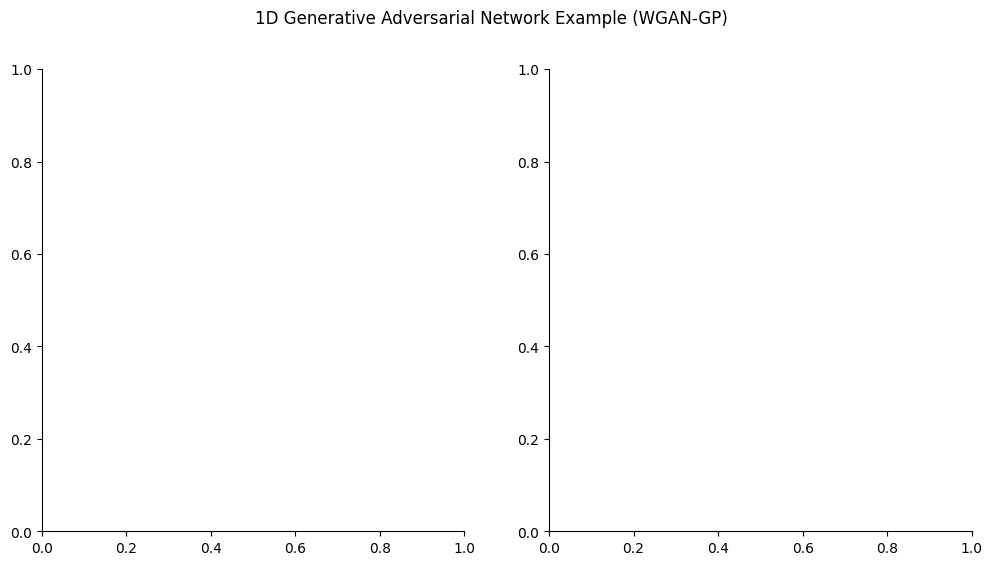

step:    0, negative critic loss:  -0.0551, time:   0 s
step:   50, negative critic loss:   0.4566, time:   0 s
step:  100, negative critic loss:   0.4274, time:   1 s
step:  150, negative critic loss:   0.3978, time:   1 s
step:  200, negative critic loss:   0.2653, time:   2 s
step:  250, negative critic loss:   0.1127, time:   2 s
step:  300, negative critic loss:   0.0664, time:   3 s
step:  350, negative critic loss:   0.1274, time:   4 s
step:  400, negative critic loss:   0.0712, time:   4 s
step:  450, negative critic loss:   0.1617, time:   5 s
step:  500, negative critic loss:   0.1418, time:   5 s
step:  550, negative critic loss:   0.1221, time:   6 s
step:  600, negative critic loss:   0.1421, time:   6 s
step:  650, negative critic loss:   0.1477, time:   7 s
step:  700, negative critic loss:   0.1533, time:   7 s
step:  750, negative critic loss:   0.1132, time:   8 s
step:  800, negative critic loss:   0.1313, time:   8 s
step:  850, negative critic loss:   0.1634, time

In [5]:
Gaussian_out = False
mu = 0.5
sigma = 1.5

Uniform_out = False
left_v = -1.
right_v = 4.

Discrete_out = True
dis_v_list = [-3., 1.5, 3.2]  # discrete values as a list
dis_p_list = [0.3, 0.5, 0.2]   # probabilities for the discrete values

hist = True if Discrete_out else False
seed = 100  # Fix the random seed
n_step = 4000  # Run the training procedure for 1450 steps.

savepath = '/content/WassersteinGANTest_1D/'  # the directory and the file name to save the generated pdf during training
file_name = 'Discrete_pdf.gif'
data = Dataset(Gaussian_out, mu, sigma, Uniform_out, left_v, right_v, Discrete_out, dis_v_list, dis_p_list, seed)  # Initialize the toy data object.
vis = Visualization(path = savepath, name = file_name, save_animation=True, hist = hist)  # Create the visualization and optionally save the resulting animation.
model = GAN(n_step=n_step, save_path = os.path.join(savepath, "TrainDiscreteModel.ckpt"), callback=vis.plot_progress, seed=seed).fit(data)  # Fit the data and plot the progress.


In [6]:
# Sample data from the loaded model
samples = model.model_sample(n_samples=10000)
samples = np.where(samples<-0.75, -3, np.where(samples>2.35, 3.2, 1.5))

#test_samples = np.random.uniform(left_v, right_v, 10000)  #  = -1.
test_samples = np.random.choice(dis_v_list, 10000, p=dis_p_list)

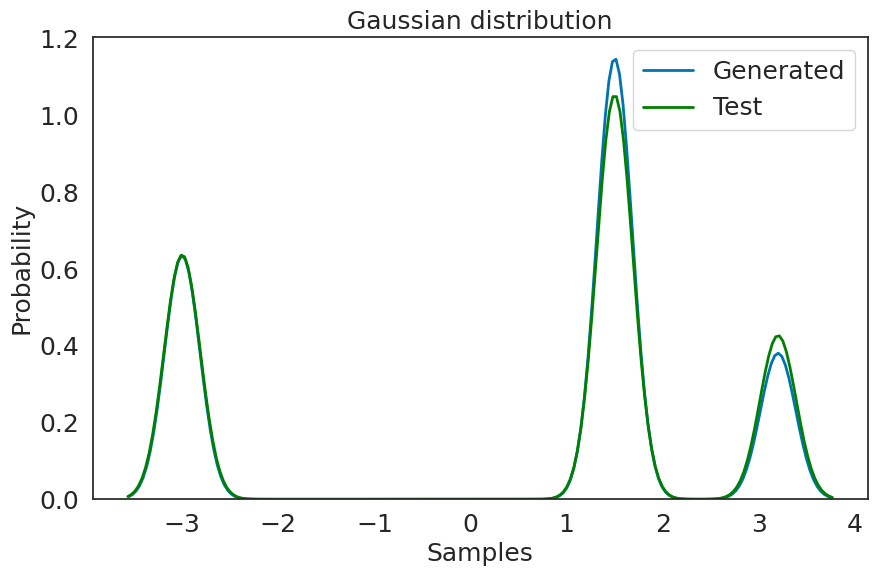

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area
plt.figure(figsize=(10, 6))

# Plot KDE (smooth density curve)
sns.kdeplot(samples, color='blue', bw_adjust=0.5, linewidth=2, label='Generated')
sns.kdeplot(test_samples, color='green', bw_adjust=0.5, linewidth=2, label='Test')

# Add titles and labels with specified font sizes
plt.title('Gaussian distribution', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Probability', fontsize=18)

# Update tick label font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Update legend with a larger font size
plt.legend(fontsize=18)

# Show plot
plt.show()




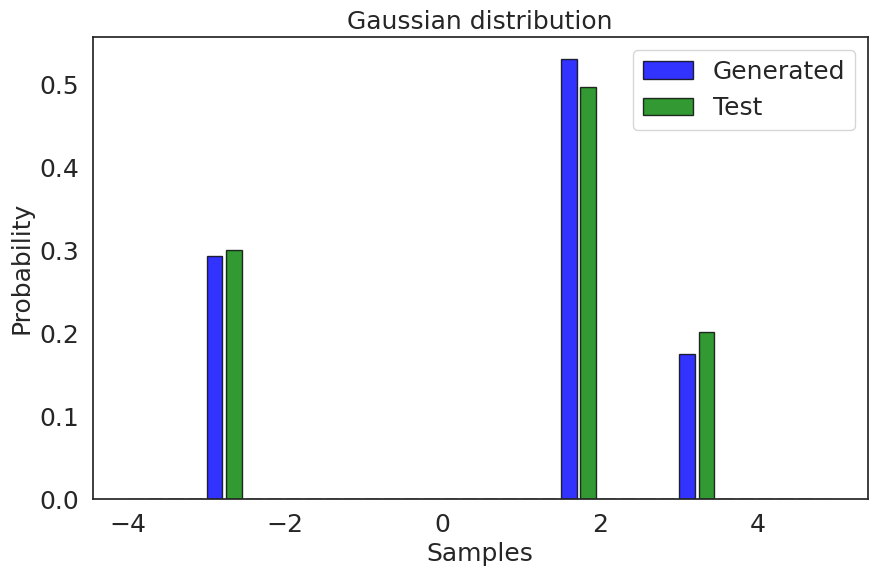

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area
plt.figure(figsize=(10, 6))

# Plot histograms with transparency
#plt.hist(samples, bins=30, alpha=0.5, density=True, color='blue', edgecolor='black', label='Generated')
#plt.hist(test_samples, bins=30, alpha=0.5, density=True, color='green', edgecolor='black', label='Test')



bin_edges = np.arange(36)/4 - 4
barwidth = 0.2
arr = samples
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
plt.bar(edges[:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='Generated', align='edge')
arr = test_samples
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
plt.bar(edges[1:], samp, width=barwidth, alpha=0.8, edgecolor='black', color='green', label='Test',align='edge')

# Add titles and labels with specified font sizes
plt.title('Gaussian distribution', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Probability', fontsize=18)

# Update tick label font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Update legend with a larger font size
plt.legend(fontsize=18)

# Show plot
plt.show()
